In [1]:
# Install/import dependencies (this is mostly for Google Colab, as the other dependences are available by default in Colab)
try:
  import datasets
  import gradio as gr
  import torchmetrics
  import pycocotools
except ModuleNotFoundError:

  # If a module isn't found, install it
  !pip install -U datasets gradio # -U stands for "upgrade" so we'll get the latest version by default
  !pip install -U torchmetrics[detection]

  import datasets
  import gradio as gr

  # Required for evalation
  import torchmetrics
  import pycocotools # make sure we have this for torchmetrics

import random

import numpy as np

import torch
import transformers

# Check versions (as long as you've got the following versions or higher, you should be good)
print(f"Using transformers version: {transformers.__version__}")
print(f"Using datasets version: {datasets.__version__}")
print(f"Using torch version: {torch.__version__}")
print(f"Using torchmetrics version: {torchmetrics.__version__}")

Using transformers version: 4.57.3
Using datasets version: 4.4.1
Using torch version: 2.9.0+cu126
Using torchmetrics version: 1.8.2


In [2]:
from datasets import load_dataset

# Load our Trashify dataset
dataset = load_dataset(path="mrdbourke/trashify_manual_labelled_images")

dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00003.parquet:   0%|          | 0.00/334M [00:00<?, ?B/s]

data/train-00001-of-00003.parquet:   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00002-of-00003.parquet:   0%|          | 0.00/345M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1128 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'image_id', 'annotations', 'label_source', 'image_source'],
        num_rows: 1128
    })
})

In [3]:
print(f"[INFO] Length of original dataset: {len(dataset['train'])}")
print(f"[INFO] Dataset features:")

from pprint import pprint

pprint(dataset['train'].features)

[INFO] Length of original dataset: 1128
[INFO] Dataset features:
{'annotations': {'area': List(Value('float32')),
                 'bbox': List(List(Value('float32'), length=4)),
                 'category_id': List(ClassLabel(names=['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm'])),
                 'file_name': List(Value('string')),
                 'image_id': List(Value('int64')),
                 'iscrowd': List(Value('int64'))},
 'image': Image(mode=None, decode=True),
 'image_id': Value('int64'),
 'image_source': Value('string'),
 'label_source': Value('string')}


In [4]:
# View a single sample of the dataset
dataset["train"][42]

{'image': <PIL.Image.Image image mode=RGB size=960x1280>,
 'image_id': 745,
 'annotations': {'file_name': ['094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg',
   '094f4f41-dc07-4704-96d7-8d5e82c9edb9.jpeg'],
  'image_id': [745, 745, 745],
  'category_id': [5, 1, 0],
  'bbox': [[333.1000061035156,
    611.2000122070312,
    244.89999389648438,
    321.29998779296875],
   [504.0, 612.9000244140625, 451.29998779296875, 650.7999877929688],
   [202.8000030517578,
    366.20001220703125,
    532.9000244140625,
    555.4000244140625]],
  'iscrowd': [0, 0, 0],
  'area': [78686.3671875, 293706.03125, 295972.65625]},
 'label_source': 'manual_prodigy_label',
 'image_source': 'manual_taken_photo'}

In [5]:
dataset["train"][42]["annotations"]["bbox"][0]

[333.1000061035156, 611.2000122070312, 244.89999389648438, 321.29998779296875]

In [6]:
# Get the categories from the dataset
# Note: This requires the dataset to have been uploaded with this information setup, not all datasets will have this available.
categories = dataset["train"].features["annotations"]["category_id"]

# Get the names attribute
categories.feature.names

['bin', 'hand', 'not_bin', 'not_hand', 'not_trash', 'trash', 'trash_arm']

In [7]:
# Map ID's to class names and vice versa
id2label = {i: class_name for i, class_name in enumerate(categories.feature.names)}
label2id = {value: key for key, value in id2label.items()}

print(f"Label to ID mapping:\n{label2id}\n")
print(f"ID to label mapping:\n{id2label}")
# id2label, label2id

Label to ID mapping:
{'bin': 0, 'hand': 1, 'not_bin': 2, 'not_hand': 3, 'not_trash': 4, 'trash': 5, 'trash_arm': 6}

ID to label mapping:
{0: 'bin', 1: 'hand', 2: 'not_bin', 3: 'not_hand', 4: 'not_trash', 5: 'trash', 6: 'trash_arm'}


In [8]:
# Make colour dictionary
colour_palette = {
    'bin': (0, 0, 224),         # Bright Blue (High contrast with greenery) in format (red, green, blue)
    'not_bin': (255, 80, 80),   # Light Red to indicate negative class

    'hand': (148, 0, 211),      # Dark Purple (Contrasts well with skin tones)
    'not_hand': (255, 80, 80),  # Light Red to indicate negative class

    'trash': (0, 255, 0),       # Bright Green (For trash-related items)
    'not_trash': (255, 80, 80), # Light Red to indicate negative class

    'trash_arm': (255, 140, 0), # Deep Orange (Highly visible)
}

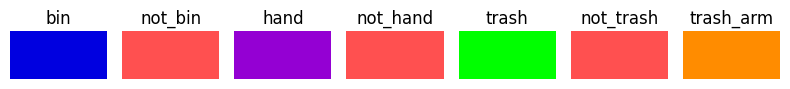

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize RGB values to 0-1 range
def normalize_rgb(rgb_tuple):
    return tuple(x/255 for x in rgb_tuple)

# Turn colors into normalized RGB values for matplotlib
colors_and_labels_rgb = [(key, normalize_rgb(value)) for key, value in colour_palette.items()]

# Create figure and axis
fig, ax = plt.subplots(1, 7, figsize=(8, 1))

# Flatten the axis array for easier iteration
ax = ax.flatten()

# Plot each color square
for idx, (label, color) in enumerate(colors_and_labels_rgb):
    ax[idx].add_patch(plt.Rectangle(xy=(0, 0),
                                    width=1,
                                    height=1,
                                    facecolor=color))
    ax[idx].set_title(label)
    ax[idx].set_xlim(0, 1)
    ax[idx].set_ylim(0, 1)
    ax[idx].axis('off')

plt.tight_layout()
plt.show()

In [10]:
import PIL

def half_image(image: PIL.Image) -> PIL.Image:
    """
    Resizes a given input image by half and returns the smaller version.
    """
    return image.resize(size=(image.size[0] // 2, image.size[1] // 2))

def half_boxes(boxes):
    """
    Halves an array/tensor of input boxes and returns them. Necessary for plotting them on a half-sized image.

    For example:

    boxes = [100, 100, 100, 100]
    half_boxes = half_boxes(boxes)
    print(half_boxes)

    >>> [50, 50, 50, 50]
    """
    if isinstance(boxes, list):
        # If boxes are list of lists, then we have multiple boxes
        for box in boxes:
            if isinstance(box, list):
                return [[coordinate // 2 for coordinate in box] for box in boxes]
            else:
                return [coordinate // 2 for coordinate in boxes]

    if isinstance(boxes, np.ndarray):
        return (boxes // 2)

    if isinstance(boxes, torch.Tensor):
        return (boxes // 2)

# Test the functions
image_test = dataset["train"][42]["image"]
image_test_half = half_image(image_test)
print(f"[INFO] Original image size: {image_test.size} | Half image size: {image_test_half.size}")

boxes_test_list = [100, 100, 100, 100]
print(f"[INFO] Original boxes: {boxes_test_list} | Half boxes: {half_boxes(boxes_test_list)}")

boxes_test_torch = torch.tensor([100.0, 100.0, 100.0, 100.0])
print(f"[INFO] Original boxes: {boxes_test_torch} | Half boxes: {half_boxes(boxes_test_torch)}")

[INFO] Original image size: (960, 1280) | Half image size: (480, 640)
[INFO] Original boxes: [100, 100, 100, 100] | Half boxes: [50, 50, 50, 50]
[INFO] Original boxes: tensor([100., 100., 100., 100.]) | Half boxes: tensor([50., 50., 50., 50.])


[INFO] Showing training sample from index: 947
Boxes in XYWH format: tensor([[171., 268., 110., 116.],
        [109., 323., 110., 116.],
        [ 76., 389.,  66.,  71.],
        [103., 230., 270., 238.],
        [141., 577.,  36.,  56.],
        [246., 541.,  46.,  94.],
        [154.,   3., 235., 227.]])
Boxes XYXY: tensor([[171., 268., 281., 384.],
        [109., 323., 219., 439.],
        [ 76., 389., 142., 460.],
        [103., 230., 373., 468.],
        [141., 577., 177., 633.],
        [246., 541., 292., 635.],
        [154.,   3., 389., 230.]])
Label names: ['trash', 'hand', 'not_trash', 'bin', 'not_trash', 'not_trash', 'not_bin']
Colour codes: [(0, 255, 0), (148, 0, 211), (255, 80, 80), (0, 0, 224), (255, 80, 80), (255, 80, 80), (255, 80, 80)]


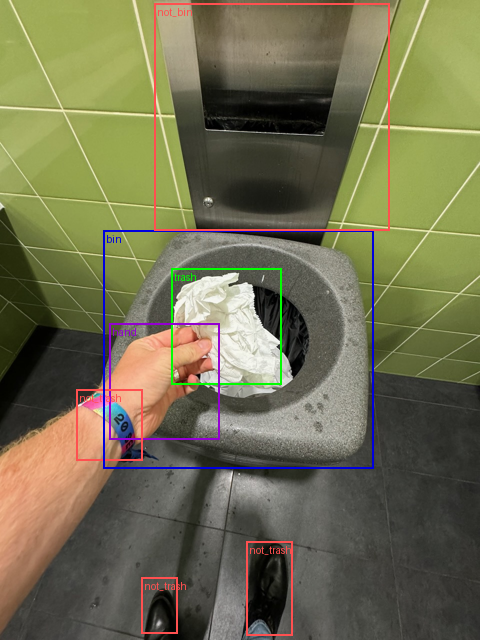

In [11]:
# Plotting a bounding box on a single image
import random
import torch

from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

# 1. Select a random sample from our dataset
random_index = random.randint(0, len(dataset["train"]) - 1)
print(f"[INFO] Showing training sample from index: {random_index}")
random_sample = dataset["train"][random_index]

# 2. Get image and boxes from random sample
random_sample_image = random_sample["image"]
random_sample_boxes = random_sample["annotations"]["bbox"]

# Optional: Half the image and boxes
half_random_sample_image = half_image(random_sample_image)
half_random_sample_boxes = half_boxes(random_sample_boxes)

# 3. Turn box coordinates into a tensor (XYWH)
boxes_xywh = torch.tensor(half_random_sample_boxes)
print(f"Boxes in XYWH format: {boxes_xywh}")

# 4. Convert boxes from XYWH → XYXY
boxes_xyxy = box_convert(
    boxes=boxes_xywh,
    in_fmt="xywh",
    out_fmt="xyxy"
)
print(f"Boxes XYXY: {boxes_xyxy}")

# ✅ 5. Get the ClassLabel feature
categories = dataset["train"].features["annotations"]["category_id"].feature

# 6. Convert category IDs to label names
random_sample_label_names = [
    categories.int2str(x)
    for x in random_sample["annotations"]["category_id"]
]

# 7. Assign colors per label
random_sample_colours = [
    colour_palette[label_name]
    for label_name in random_sample_label_names
]

print(f"Label names: {random_sample_label_names}")
print(f"Colour codes: {random_sample_colours}")

# 8. Draw bounding boxes
boxed_image = draw_bounding_boxes(
    image=pil_to_tensor(half_random_sample_image),
    boxes=boxes_xyxy,
    colors=random_sample_colours,
    labels=random_sample_label_names,
    width=2,
    label_colors=random_sample_colours
)

# 9. Convert to PIL for display
to_pil_image(boxed_image)


In [12]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.module") # turn off warnings for loading the model (feel free to comment this if you want to see the warnings)

from transformers import AutoModelForObjectDetection

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"

model = AutoModelForObjectDetection.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    label2id=label2id,
    id2label=id2label,
    # Original model was trained with a different number of output
    # So it'll ignore any mismatched sizes (e.g. 91 vs. 7)
    ignore_mismatched_sizes=True,
)

# Uncomment to see full model architecture
# model

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

In [13]:
print(f"[INFO] Final classification layer: {model.class_embed}\n")
print(f"[INFO] Final box regression layer: {model.bbox_embed}")

[INFO] Final classification layer: ModuleList(
  (0-5): 6 x Linear(in_features=256, out_features=7, bias=True)
)

[INFO] Final box regression layer: ModuleList(
  (0-5): 6 x RTDetrV2MLPPredictionHead(
    (layers): ModuleList(
      (0-1): 2 x Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=4, bias=True)
    )
  )
)


In [14]:
# Count the number of parameters in the model
def count_parameters(model):
    """Takes in a PyTorch model and returns the number of parameters."""
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_parameters:,}")
    print(f"Trainable parameters (will be updated): {trainable_parameters:,}")
    print(f"Non-trainable parameters (will not be updated): {non_trainable_parameters:,}")

count_parameters(model)

Total parameters: 42,741,357
Trainable parameters (will be updated): 42,741,357
Non-trainable parameters (will not be updated): 0


In [15]:
from transformers import AutoModelForObjectDetection

# Setup the model
def create_model(pretrained_model_name_or_path: str = MODEL_NAME,
                 label2id: dict = label2id,
                 id2label: dict = id2label):
    """Creates and returns an instance of AutoModelForObjectDetection.

    Args:
        pretrained_model_name_or_path (str): The name or path of the pretrained model to load.
            Defaults to MODEL_NAME.
        label2id (dict): A dictionary mapping class labels to IDs. Defaults to label2id.
        id2label (dict): A dictionary mapping class IDs to labels. Defaults to id2label.

    Returns:
        AutoModelForObjectDetection: A pretrained model for object detection with number of output
            classes equivalent to len(label2id).
    """
    model = AutoModelForObjectDetection.from_pretrained(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        label2id=label2id,
        id2label=id2label,
        ignore_mismatched_sizes=True, # default
    )
    return model

In [17]:
# Create a new model instance
model = create_model()
# model

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([7]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- model.decod

In [18]:
from transformers import AutoImageProcessor

MODEL_NAME = "PekingU/rtdetr_v2_r50vd"
# MODEL_NAME = "facebook/detr-resnet-50" # Could also use this model as an another experiment

# Load the image processor
image_processor = AutoImageProcessor.from_pretrained(pretrained_model_name_or_path=MODEL_NAME,
                                                     use_fast=True) # load the fast version of the processor

# Check out the image processor
image_processor

preprocessor_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

RTDetrImageProcessorFast {
  "crop_size": null,
  "data_format": "channels_first",
  "default_to_square": false,
  "device": null,
  "disable_grouping": null,
  "do_center_crop": null,
  "do_convert_annotations": true,
  "do_convert_rgb": null,
  "do_normalize": false,
  "do_pad": false,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "RTDetrImageProcessorFast",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "input_data_format": null,
  "pad_size": null,
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "return_segmentation_masks": null,
  "return_tensors": null,
  "size": {
    "height": 640,
    "width": 640
  }
}

In [22]:
# Set image size
IMAGE_SIZE = 640 # we could try other sizes here: 300x300, 480x480, 512x512, 640x640, 800x800 (best to experiment and see which works best)

# Create a new instance of the image processor with the desired image size
image_processor = AutoImageProcessor.from_pretrained(
    pretrained_model_name_or_path=MODEL_NAME,
    use_fast=True, # use the fast preprocessor
    format="coco_detection", # this is the default
    do_convert_annotations=True, # defaults to True, converts boxes to (center_x, center_y, width, height) in range [0, 1]
    size={"shortest_edge": IMAGE_SIZE,
          "longest_edge": IMAGE_SIZE},
    return_segmentation_masks=True,
    do_pad=True # make sure all images have 640x640 size thanks to padding
)

# Optional: View the docstring of our image_processor.preprocess function
# image_processor.preprocess?

# Check out our new image processor size
image_processor.size

{'shortest_edge': 640, 'longest_edge': 640}

In [23]:
# Preprocess our target sample
random_sample_preprocessed_image_only = image_processor(images=random_sample["image"],
                                                        annotations=None, # no annotations this time
                                                        masks_path=None, # no masks inputs
                                                        return_tensors="pt") # return as PyTorch tensors

# Uncomment to see the full output
# print(random_sample_preprocessed_image_only)

# Print out the keys of the preprocessed image
print(random_sample_preprocessed_image_only.keys())

KeysView({'pixel_mask': tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]]), 'pixel_values': tensor([[[[0.6157, 0.6078, 0.6000,  ..., 0.6392, 0.6314, 0.6353],
          [0.6157, 0.6078, 0.6000,  ..., 0.6392, 0.6353, 0.6314],
          [0.6118, 0.6078, 0.6039,  ..., 0.6431, 0.6392, 0.6353],
          ...,
          [0.2667, 0.2549, 0.2510,  ..., 0.2000, 0.2039, 0.2000],
          [0.2549, 0.2510, 0.2549,  ..., 0.2000, 0.2000, 0.1961],
          [0.2471, 0.2471, 0.2549,  ..., 0.2039, 0.2039, 0.2000]],

         [[0.6667, 0.6588, 0.6510,  ..., 0.6745, 0.6667, 0.6706],
          [0.6667, 0.6588, 0.6510,  ..., 0.6745, 0.6706, 0.6667],
          [0.6627, 0.6588, 0.6549,  ..., 0.6784, 0.6745, 0.6706],
          ...,
          [0.2471, 0.2353, 0.2353,  ..., 0.1961, 0.2000, 0.1961],
          [0.2353, 0.2314, 0.2392,  ..., 

In [24]:
# Uncomment to inspect all preprocessed pixel values
# print(random_sample_preprocessed_image_only["pixel_values"][0])

print(f"[INFO] Original image shape: {random_sample['image'].size} -> [width, height]")
print(f"[INFO] Preprocessed image shape: {random_sample_preprocessed_image_only['pixel_values'].shape} -> [batch_size, colour_channles, height, width]")

[INFO] Original image shape: (960, 1280) -> [width, height]
[INFO] Preprocessed image shape: torch.Size([1, 3, 640, 480]) -> [batch_size, colour_channles, height, width]


In [25]:
random_sample_outputs = model(
    pixel_values=random_sample_preprocessed_image_only["pixel_values"], # model expects input [batch_size, color_channels, height, width]
    # pixel_mask=random_sample_preprocessed_image_only["pixel_mask"], # some object detection models expect masks
)

In [26]:
# Check the keys of the output
random_sample_outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

In [27]:
# Inspect logits output shape
output_logits = random_sample_outputs.logits
print(f"[INFO] Output logits shape: {output_logits.shape} -> [1 image, 300 boxes, 7 classes]")

[INFO] Output logits shape: torch.Size([1, 300, 7]) -> [1 image, 300 boxes, 7 classes]


In [28]:
# Inspect predicted boxes output shape
output_pred_boxes = random_sample_outputs.pred_boxes
print(f"[INFO] Output predicted boxes shape: {output_pred_boxes.shape} -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]")

[INFO] Output predicted boxes shape: torch.Size([1, 300, 4]) -> [1 image, 300 boxes, 4 coordinates (center_x, center_y, width, height)]


In [29]:
# Single example predicted bounding box coordinates
print(f"[INFO] Example output box: {output_pred_boxes[:, 0, :][0].detach()} -> (center_x, center_y, width, height)")

[INFO] Example output box: tensor([0.4932, 0.5062, 0.4655, 0.2836]) -> (center_x, center_y, width, height)
